In [20]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split

In [3]:
df_ecommerce= pd.read_json('1_ecommerce.jsonl', lines=True)
df_ecommerce.head(5)

,session,events
0,12899779,"[{'aid': 59625, 'ts': 1661724000278, 'type': '..."
1,12899780,"[{'aid': 1142000, 'ts': 1661724000378, 'type':..."
2,12899781,"[{'aid': 141736, 'ts': 1661724000559, 'type': ..."
3,12899782,"[{'aid': 1669402, 'ts': 1661724000568, 'type':..."
4,12899783,"[{'aid': 255297, 'ts': 1661724000572, 'type': ..."


In [4]:
df_ecommerce.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1671803 entries, 0 to 1671802
Data columns (total 2 columns):
 #   Column   Non-Null Count    Dtype 
---  ------   --------------    ----- 
 0   session  1671803 non-null  int64 
 1   events   1671803 non-null  object
dtypes: int64(1), object(1)
memory usage: 25.5+ MB


In [5]:
# for each session, we will create a list of items that the user has clicked on, removing duplicates
clicks_items_list = []
carts_items_list = []
orders_items_list = []

for events in df_ecommerce.events:
    clicks = []
    carts = []
    orders = []
    for e in events:
        if e['type'] == 'clicks':
            clicks.append(e['aid'])
        if e['type'] == 'carts':
            carts.append(e['aid'])
        if e['type'] == 'orders':
            orders.append(e['aid'])

    clicks_items_list.append(list(clicks))
    carts_items_list.append(list(carts))
    orders_items_list.append(list(orders))

In [6]:
df_ecommerce['clicks'] = clicks_items_list
df_ecommerce['carts'] = carts_items_list
df_ecommerce['orders'] = orders_items_list
df = df_ecommerce.drop(columns=["events"], axis=1)

In [7]:
df.head()

,session,clicks,carts,orders
0,12899779,[59625],[],[]
1,12899780,"[1142000, 582732, 973453, 736515, 1142000]",[],[]
2,12899781,"[141736, 199008, 57315, 194067, 199008, 199008...",[199008],[]
3,12899782,"[1669402, 1494780, 1494780, 1494780, 1674681, ...","[1494780, 413962, 779477, 562753, 476063, 7794...","[1669402, 829180, 1696036, 479970, 834354, 103..."
4,12899783,"[255297, 1114789, 255297, 300127, 198385, 3001...",[],[]


In [8]:
# Calcolare la lunghezza delle liste per ogni categoria (assumiamo che df_ecommerce sia già definito)
clicks_length = df_ecommerce['clicks'].apply(len)
carts_length = df_ecommerce['carts'].apply(len)
orders_length = df_ecommerce['orders'].apply(len)

In [9]:
# Funzione per aggiungere i conteggi sopra le barre (con spazio regolato)
def add_counts(ax, data, color, bins):
    counts, bins_edges, patches = ax.hist(data, bins=bins, edgecolor='black', alpha=0.7, color=color, range=(0, bins))
    ax.set_xticks(bins_edges)
    for count, patch in zip(counts, patches):
        height = patch.get_height()
        # Aggiungi il numero sopra ogni barra con un po' di margine
        ax.text(patch.get_x() + patch.get_width() / 2, height + 1, f'{int(count)}',
                ha='left', va='bottom', fontsize=8, rotation=20)

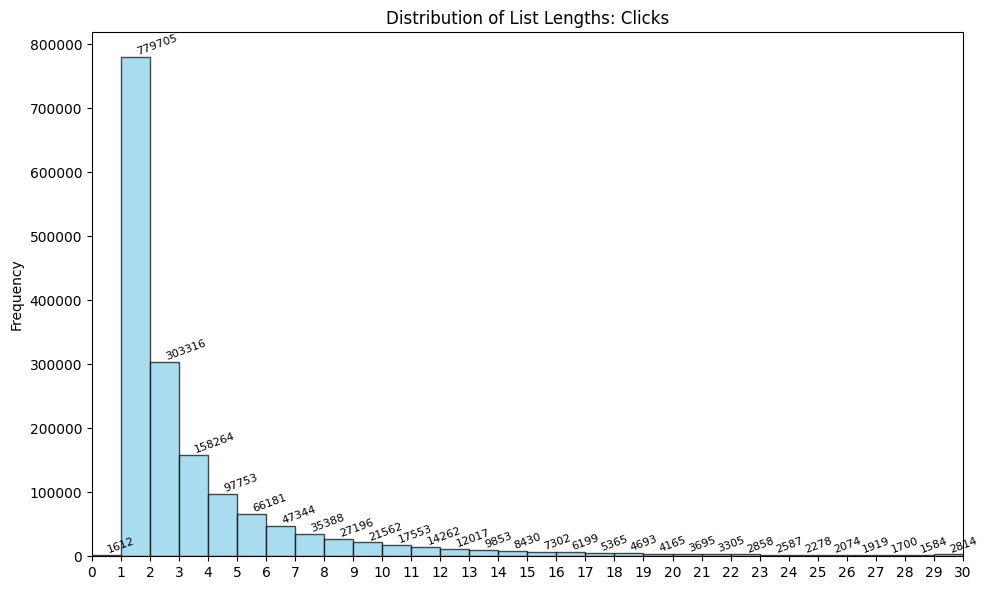

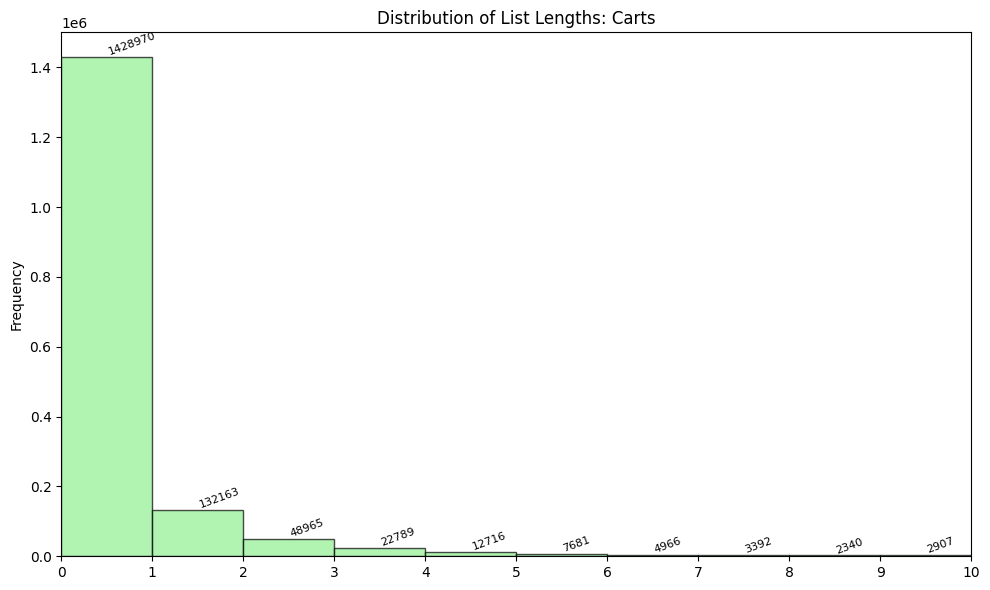

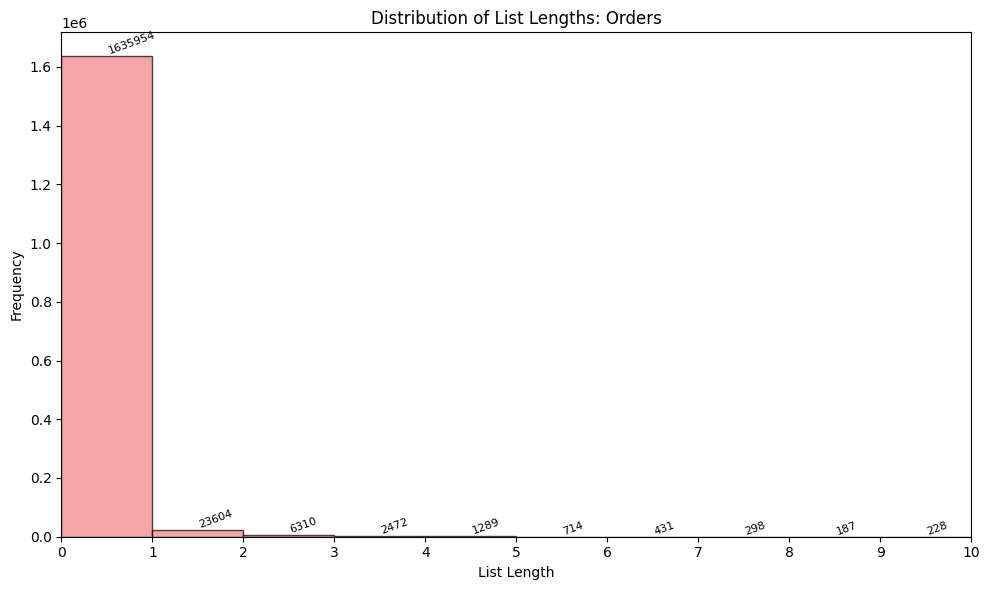

In [10]:
plt.figure(figsize=(10, 6))
ax1 = plt.gca()  # Ottieni l'asse corrente
add_counts(ax1, clicks_length, color='skyblue', bins=30)
ax1.set_title('Distribution of List Lengths: Clicks')
ax1.set_ylabel('Frequency', fontsize=10)
ax1.set_xlim(0, 30)  # Limitiamo l'asse x da 0 a 30
plt.tight_layout()  # Ottimizza il layout
plt.show()

# Grafico per Carts
plt.figure(figsize=(10, 6))
ax2 = plt.gca()  # Ottieni l'asse corrente
add_counts(ax2, carts_length, color='lightgreen', bins=10)
ax2.set_title('Distribution of List Lengths: Carts')
ax2.set_ylabel('Frequency', fontsize=10)
ax2.set_xlim(0, 10)  # Limitiamo l'asse x da 0 a 30
plt.tight_layout()  # Ottimizza il layout
plt.show()

# Grafico per Orders
plt.figure(figsize=(10, 6))
ax3 = plt.gca()  # Ottieni l'asse corrente
add_counts(ax3, orders_length, color='lightcoral', bins=10)
ax3.set_title('Distribution of List Lengths: Orders')
ax3.set_xlabel('List Length', fontsize=10)
ax3.set_ylabel('Frequency', fontsize=10)
ax3.set_xlim(0, 10)  # Limitiamo l'asse x da 0 a 30
plt.tight_layout()  # Ottimizza il layout
plt.show()

In [11]:
# takes only the session with items length higher than 20
df_truncated = df[df['clicks'].apply(lambda x: len(x) > 10)]
df = df_truncated.copy()
# redefine index
df.reset_index(drop=True, inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 115929 entries, 0 to 115928
Data columns (total 4 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   session  115929 non-null  int64 
 1   clicks   115929 non-null  object
 2   carts    115929 non-null  object
 3   orders   115929 non-null  object
dtypes: int64(1), object(3)
memory usage: 3.5+ MB


In [12]:
# Esplodiamo ogni colonna (clicks, carts, orders)
df_clicks = df[['session', 'clicks']].explode('clicks').rename(columns={'clicks': 'item'}).dropna(subset=['item'])
df_carts = df[['session', 'carts']].explode('carts').rename(columns={'carts': 'item'}).dropna(subset=['item'])
df_orders = df[['session', 'orders']].explode('orders').rename(columns={'orders': 'item'}).dropna(subset=['item'])

# Uniamo i dataframe esplosi
df_concat = pd.concat([df_clicks, df_carts, df_orders])

# Creiamo una colonna che indica dove appare l'item
df_concat['click'] = df_concat['item'].isin(df_clicks['item']).astype(int)
df_concat['cart'] = df_concat['item'].isin(df_carts['item']).astype(int)
df_concat['order'] = df_concat['item'].isin(df_orders['item']).astype(int)

# Rimuoviamo i duplicati (potrebbero esserci più voci per la stessa sessione e lo stesso item)
df_concat = df_concat.drop_duplicates(subset=['session', 'item'])

# Risultato finale: il dataframe con sessione, item, e le colonne piene/vuote per ogni categoria
df_concat

,session,item,click,cart,order
0,12899782,1669402,1,1,1
0,12899782,1494780,1,1,0
0,12899782,1674681,1,1,0
0,12899782,602722,1,1,0
0,12899782,1596098,1,1,1
...,...,...,...,...,...
115356,14557158,1419870,1,1,1
115600,14562469,326854,1,0,1
115796,14567152,459953,1,1,1
115796,14567152,1038897,1,1,1


In [13]:
print(f"The user-item after filtering should be {df_concat.session.nunique()} x {df_concat.item.nunique()}")

The user-item after filtering should be 115929 x 501272


In [33]:
def sgd_matrix_factorization(df, k=20, alpha=0.01, lambda_reg=0.1, num_epochs=20, w_click=1, w_cart=3, w_order=5, test_size=0.2, validation_size=0.1):
    """
    Stochastic Gradient Descent (SGD) for Unconstrained Matrix Factorization with user and item biases.

    Parameters:
    df : pandas.DataFrame
        Filtered dataset containing columns: 'session', 'item', 'click', 'cart', 'order'.
    k : int
        Number of latent factors.
    alpha : float
        Learning rate.
    lambda_reg : float
        Regularization parameter.
    num_epochs : int
        Number of training epochs.
    w_click, w_cart, w_order : int
        Weights for click, cart, and order actions.
    test_size : float
        Fraction of the data to be used for testing.
    validation_size : float
        Fraction of the data to be used for validation.

    Returns:
    U : np.ndarray
        User latent factor matrix.
    V : np.ndarray
        Item latent factor matrix.
    b_u : np.ndarray
        User bias vector.
    b_i : np.ndarray
        Item bias vector.
    b : float
        Global bias.
    losses : list
        List of training loss values per epoch.
    val_losses : list
        List of validation loss values per epoch.
    test_loss : float
        Final loss on the test set.
    """
    # Map session (users) and items to consecutive indices
    users = {u: i for i, u in enumerate(df['session'].unique())}
    items = {i: j for j, i in enumerate(df['item'].unique())}

    num_users = len(users)
    num_items = len(items)

    # Initialize U, V, and biases
    U = np.random.rand(num_users, k)
    V = np.random.rand(num_items, k)
    b_u = np.zeros(num_users)
    b_i = np.zeros(num_items)
    b = 0  # Global bias

    # Create (u, i, r_ui) tuples for all interactions
    data = []

    # Assign ratings to interactions
    for _, row in df.iterrows():
        u = users[row['session']]
        i = items[row['item']]

        if row['order'] > 0:
            r_ui = w_order
        elif row['cart'] > 0:
            r_ui = w_cart
        elif row['click'] > 0:
            r_ui = w_click
        else:
            continue  # Skip interactions with no recorded action

        data.append((u, i, r_ui))

    # Split the data into training, validation, and test sets
    train_data, test_data = train_test_split(data, test_size=test_size, random_state=42)
    train_data, val_data = train_test_split(train_data, test_size=validation_size, random_state=42)

    # Compute global bias as the mean rating
    if train_data:
        b = np.mean([r for _, _, r in train_data])

    print("Datasets created! Starting training...")

    # Training using SGD
    losses = []
    val_losses = []

    for epoch in range(num_epochs):
        np.random.shuffle(train_data)  # Shuffle data to improve convergence
        total_loss = 0
        total_val_loss = 0

        U_temp = U.copy()
        V_temp = V.copy()

        # Training phase
        for u, i, r_ui in train_data:
            pred = b + b_u[u] + b_i[i] + np.dot(U[u, :], V[i, :])
            e_ui = r_ui - pred  # Error

            # Update biases
            b_u[u] += alpha * (e_ui - lambda_reg * b_u[u])
            b_i[i] += alpha * (e_ui - lambda_reg * b_i[i])

            # Update latent factors using temporary matrices
            U_temp[u, :] += alpha * (e_ui * V[i, :] - lambda_reg * U[u, :])
            V_temp[i, :] += alpha * (e_ui * U[u, :] - lambda_reg * V[i, :])

            total_loss += e_ui ** 2  # Sum of squared errors
        total_loss /= len(train_data)
        total_loss = np.sqrt(total_loss)

        # Copy back updated matrices
        U = U_temp
        V = V_temp

        # Validation phase (calculate validation loss)
        for u, i, r_ui in val_data:
            pred = b + b_u[u] + b_i[i] + np.dot(U[u, :], V[i, :])
            e_ui = r_ui - pred  # Error
            total_val_loss += e_ui ** 2
        total_val_loss /= len(val_data)
        total_val_loss = np.sqrt(total_val_loss)

        # Append losses for the current epoch
        losses.append(total_loss)
        val_losses.append(total_val_loss)

        print(f"Epoch {epoch+1}/{num_epochs}, RMSE Train Loss: {total_loss:.4f}, RMSE Val Loss: {total_val_loss:.4f}")

    # Test phase (calculate test loss)
    test_loss = 0
    for u, i, r_ui in test_data:
        pred = b + b_u[u] + b_i[i] + np.dot(U[u, :], V[i, :])
        e_ui = r_ui - pred  # Error
        test_loss += e_ui ** 2
    test_loss /= len(test_data)
    test_loss = np.sqrt(test_loss)

    print(f"Final Test RMSE: {test_loss:.4f}")

    return U, V, b_u, b_i, b, losses, val_losses, test_loss

In [34]:
U, V, b_u, b_i, b, losses, val_losses, test_loss = sgd_matrix_factorization(df_concat, k=20, alpha=0.001)

Datasets created! Starting training...
Epoch 1/20, RMSE Train Loss: 5.2555, RMSE Val Loss: 4.5647
Epoch 2/20, RMSE Train Loss: 4.4434, RMSE Val Loss: 4.1508
Epoch 3/20, RMSE Train Loss: 3.9712, RMSE Val Loss: 3.9511
Epoch 4/20, RMSE Train Loss: 3.6739, RMSE Val Loss: 4.0178
Epoch 5/20, RMSE Train Loss: 3.5067, RMSE Val Loss: 3.9245
Epoch 6/20, RMSE Train Loss: 3.2088, RMSE Val Loss: 3.2287
Epoch 7/20, RMSE Train Loss: 2.8898, RMSE Val Loss: 3.0508
Epoch 8/20, RMSE Train Loss: 2.7174, RMSE Val Loss: 2.9199
Epoch 9/20, RMSE Train Loss: 2.5725, RMSE Val Loss: 2.8065
Epoch 10/20, RMSE Train Loss: 2.4451, RMSE Val Loss: 2.7065
Epoch 11/20, RMSE Train Loss: 2.3319, RMSE Val Loss: 2.6174
Epoch 12/20, RMSE Train Loss: 2.2306, RMSE Val Loss: 2.5376
Epoch 13/20, RMSE Train Loss: 2.1393, RMSE Val Loss: 2.4655
Epoch 14/20, RMSE Train Loss: 2.0567, RMSE Val Loss: 2.4001
Epoch 15/20, RMSE Train Loss: 1.9814, RMSE Val Loss: 2.3404
Epoch 16/20, RMSE Train Loss: 1.9126, RMSE Val Loss: 2.2857
Epoch 17/2

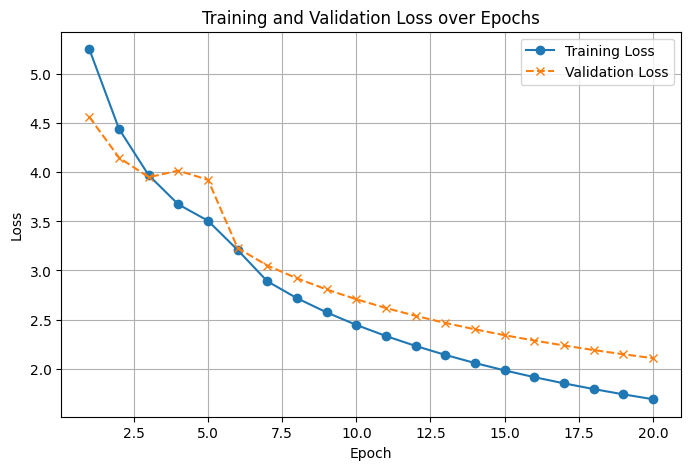

In [38]:
# Plot loss curve
plt.figure(figsize=(8, 5))

# Plot training loss
plt.plot(range(1, len(losses) + 1), losses, marker='o', linestyle='-', label='Training Loss')

# Plot validation loss
plt.plot(range(1, len(val_losses) + 1), val_losses, marker='x', linestyle='--', label='Validation Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Epochs')
plt.legend()
plt.grid(True)
plt.show()